やること
- 異常データをもとに教師あり学習を行う
    - SGDClassifier
    - knn法
    
- 教師あり学習でうまくいかなかった原因を探る
- 再構成誤差法で行ってみる

## 初期条件

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import glob
import pickle
import random

from visualize import visualization
myvs = visualization()
from select_datasets import Select_datasets as my_SD
myds = my_SD("/data7/ALL/db/ns/8k")
from sklearn.preprocessing import StandardScaler


#sample_data

path="/data6/ALL/db/ns/8k"
npz_files = glob.glob(path+"/**.npz")

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.get_cmap("Set1").colors)

d = np.load(npz_files[3])

D_df = pd.DataFrame(d["arr_0"]).T

# Constant

f_s = 12.5*10**3
th_s = 2
N = 4096
pixel_number=36

f_range = f_s/th_s
f_resolution = f_range/N

min_freq = 0.1
max_freq = 400

start = math.ceil(min_freq/f_resolution)-1
stop = math.ceil(max_freq/f_resolution)-1

x = np.arange(start+1,stop+1)*f_resolution
D_df_limfreq = D_df.iloc[:,start:stop]


## データゲット


In [2]:
# low freq

Imamura_list_data6 = glob.glob("/home/kashiwazaki/Bthesis/edata_/edata/**.npz")
df_imamura_abnormal_data = myds.concat_npz(Imamura_list_data6)
df_ImamuraAbnormal_pre = df_imamura_abnormal_data.iloc[:,start:stop]
df_ImamuraAbnormal_pre = myds.delete_0_gyou(df_ImamuraAbnormal_pre)

Imamura_list_data7 = []
for d in Imamura_list_data6:
    Imamura_list_data7.append("/data7/ALL/db/ns/8k/"+d.split("/")[-1]) 

df_ImamuraAbnormal_pre

/usr/local/conda/lib/python3.7/site-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


0           1           2           3           4           5    \
0     2659.198621  393.325415  454.642862  250.441237  233.678012  272.528985   
1     2431.311344  354.902017  409.156847  229.841866  235.572640  265.035149   
2     2638.853545  400.680499  440.336101  348.278691  331.823008  337.998418   
3     2540.309984  397.117338  415.029425  247.074044  286.974103  302.569158   
4     2566.477486  398.898264  391.118480  300.232387  293.232228  332.539906   
...           ...         ...         ...         ...         ...         ...   
1351   355.217192  156.399793  166.019671  198.384994  225.776400  252.953558   
1352   371.715936  153.365039  150.408107  196.258235  213.059565  241.756654   
1353   339.493341  172.065658  159.476038  184.333826  192.349654  251.711225   
1354   291.075822  151.676753  174.019234  180.799240  184.088673  226.376313   
1355   357.759634  151.694597  152.637684  192.016122  192.844064  259.057854   

             6           7           8           9    ...         252  \
0     293.880414  342.573205  425.434550  359.777974  ...  527.015441   
1     280.273539  287.032880  344.686973  390.559601  ...  657.387581   
2     346.077760  344.394115  431.331192  415.428903  ...  579.845709   
3     296.226159  309.196664  351.411071  463.934495  ...  614.171559   
4     371.549184  338.718384  384.407480  441.654889  ...  545.385980   
...          ...         ...         ...         ...  ...         ...   
1351  247.176909  375.444268  514.476939  365.125588  ...  566.878952   
1352  267.752230  318.121015  489.978479  399.870585  ...  548.183512   
1353  275.325876  346.019341  485.400973  355.564324  ...  585.370690   
1354  292.429978  317.118807  460.521005  362.636398  ...  594.420446   
1355  273.008020  319.235240  495.596096  378.716803  ...  562.185464   

             253         254         255         256         257         258  \
0     521.910806  564.558497  566.571556  650.762127  607.437534  546.998628   
1     549.448415  513.697915  555.560215  608.625765  574.175789  588.523898   
2     565.377236  471.485967  587.302739  577.603850  607.117386  539.095967   
3     530.049100  605.651282  593.503899  480.322189  570.295885  595.703425   
4     500.705453  579.729638  529.849471  549.735027  532.182222  502.503837   
...          ...         ...         ...         ...         ...         ...   
1351  615.428940  536.993496  619.065601  572.555419  550.982256  604.678577   
1352  613.978505  633.565723  624.532991  500.378263  545.923901  576.698857   
1353  592.977456  537.852943  564.193527  506.592656  538.986335  631.813060   
1354  566.191055  583.175991  582.232090  507.000760  451.609194  561.866751   
1355  533.685312  633.380612  505.183689  622.764235  492.910111  633.315940   

             259         260         261  
0     578.867737  624.791811  558.030378  
1     555.692123  534.614769  574.088682  
2     657.801318  541.437824  611.963983  
3     477.582883  559.419954  645.582810  
4     555.054418  577.819003  597.277680  
...          ...         ...         ...  
1351  607.688011  474.209352  572.210552  
1352  537.656098  569.138377  565.046835  
1353  577.000889  572.599777  584.777962  
1354  556.554693  552.587848  582.518347  
1355  542.249298  612.497866  585.232062  

[1356 rows x 262 columns]

In [3]:
df_ImamuraAbnormal_train,df_ImamuraAbnormal_test = myds.train_test_dataframe(df_ImamuraAbnormal_pre,test_frac=0.5)

In [4]:
# MTQ data6

MTQ_list_data6 = [
    "/data6/2108_ResolveIT_TC3/db.old/ns/8k/ns8k_20210914-050153.npz",
    "/data6/2108_ResolveIT_TC3/db.old/ns/8k/ns8k_20210914-052114.npz",
    "/data6/2108_ResolveIT_TC3/db.old/ns/8k/ns8k_20210914-050812.npz",
    "/data6/2108_ResolveIT_TC3/db.old/ns/8k/ns8k_20210914-051344.npz",
    "/data6/2108_ResolveIT_TC3/db.old/ns/8k/ns8k_20210914-055706.npz",
    "/data6/2108_ResolveIT_TC3/db.old/ns/8k/ns8k_20210915-044032.npz",
    "/data6/2108_ResolveIT_TC3/db.old/ns/8k/ns8k_20210915-062350.npz",
    "/data6/2108_ResolveIT_TC3/db.old/ns/8k/ns8k_20210915-054151.npz",
    "/data6/2108_ResolveIT_TC3/db.old/ns/8k/ns8k_20210915-051018.npz",
    "/data6/2108_ResolveIT_TC3/db.old/ns/8k/ns8k_20210915-051957.npz",
    "/data6/2108_ResolveIT_TC3/db.old/ns/8k/ns8k_20210915-045239.npz",
    "/data6/2108_ResolveIT_TC3/db.old/ns/8k/ns8k_20210915-045819.npz",]

df_data6_MTQ_noise = myds.concat_npz(target_list=MTQ_list_data6)
df_data6_MTQNoise_pre = df_data6_MTQ_noise.iloc[:,start:stop]
df_data6_MTQNoise_pre = myds.delete_0_gyou(df_data6_MTQNoise_pre)

df_data6_MTQNoise_pre

/usr/local/conda/lib/python3.7/site-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


0           1           2           3           4           5    \
0    122.664340  140.239709  157.620147  208.125353  221.679240  304.192616   
1    101.579625  146.288927  147.531055  181.814745  235.706080  241.757846   
2    174.742469  176.743400  206.853516  249.707881  247.921222  266.382415   
3    116.506971  131.797683  154.303597  180.531162  216.107921  238.373541   
4    103.937022  132.107060  161.986638  177.953472  208.649644  228.378524   
..          ...         ...         ...         ...         ...         ...   
405  126.480366  139.266176  165.905533  194.484430  224.387697  262.393386   
406  111.838091  139.780161  159.056889  187.733949  225.530316  273.565425   
407  114.580746  142.065805  158.194087  185.938047  218.934721  245.689980   
408  122.910740  149.961523  161.136982  186.378848  217.884865  220.720492   
409  112.839024  126.804785  162.296461  201.793353  200.456531  241.419938   

            6           7           8           9    ...         252  \
0    305.008833  328.150736  384.588940  391.883801  ...  575.369360   
1    278.980012  313.417692  363.851620  376.787557  ...  477.332259   
2    296.560481  371.186207  321.358129  428.663409  ...  506.428507   
3    272.505301  331.671730  352.710942  368.541949  ...  567.435968   
4    268.011547  338.231517  376.108860  381.277707  ...  577.619339   
..          ...         ...         ...         ...  ...         ...   
405  281.482346  300.679184  373.678875  393.092210  ...  687.209690   
406  251.979927  347.611834  373.057726  378.250309  ...  618.922379   
407  267.070363  334.822673  324.139044  377.045905  ...  563.567019   
408  292.657194  283.773006  341.599640  392.638389  ...  652.036306   
409  280.570575  275.298862  411.875941  339.994493  ...  578.066331   

            253         254         255         256         257         258  \
0    562.194441  561.984541  525.104199  562.163137  485.163302  560.721121   
1    492.836581  536.704859  508.035526  560.790087  487.857856  547.065450   
2    548.450248  562.532885  592.292209  606.624345  538.668668  557.160116   
3    596.940880  540.381957  533.638476  565.614697  617.196020  545.910806   
4    579.903306  554.496478  549.795936  576.940017  525.481525  585.008675   
..          ...         ...         ...         ...         ...         ...   
405  599.891526  521.259903  529.182655  623.800585  600.300525  553.137141   
406  621.974137  513.223636  581.215347  531.967888  569.317813  517.216883   
407  600.944973  613.143202  637.682013  606.927700  540.040936  508.072494   
408  551.411443  597.828049  540.396876  619.029014  582.719758  521.618100   
409  572.476047  559.357950  569.637365  590.442979  550.322258  606.270462   

            259         260         261  
0    597.370675  567.979621  539.468682  
1    572.077234  543.500773  519.364737  
2    555.724695  505.671103  569.175582  
3    520.027646  513.193707  566.050326  
4    515.670959  618.752709  538.774643  
..          ...         ...         ...  
405  544.445192  557.969274  541.588546  
406  571.957030  532.093621  551.663539  
407  504.023762  503.003812  631.760916  
408  528.372376  577.731577  597.867021  
409  639.795305  545.870246  585.105186  

[410 rows x 262 columns]

In [5]:
# MTQ data7

MTQ_list_data7 = [
    "/data7/ALL/db/ns/8k/ns8k_20220609-062512.npz",
    "/data7/ALL/db/ns/8k/ns8k_20220611-020610.npz",
    "/data7/ALL/db/ns/8k/ns8k_20220611-021235.npz",
    "/data7/ALL/db/ns/8k/ns8k_20220609-063438.npz",
    "/data7/ALL/db/ns/8k/ns8k_20220609-065340.npz",]

df_data7_MTQ_noise = myds.concat_npz(target_list=MTQ_list_data7)
df_data7_MTQNoise_pre = df_data7_MTQ_noise.iloc[:,start:stop]
df_data7_MTQNoise_pre = myds.delete_0_gyou(df_data7_MTQNoise_pre)

df_data7_MTQNoise_pre

/usr/local/conda/lib/python3.7/site-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


0           1           2           3           4           5    \
0    111.252738  122.703106  162.411272  180.485802  214.885466  220.282129   
1    120.554873  133.848305  169.800061  173.865549  222.690960  266.883744   
2    194.370670  215.445946  181.555235  222.206800  268.921125  252.061684   
3    155.880929  159.106018  180.234585  188.048337  199.054991  233.519721   
4    129.166902  134.518488  143.983195  195.380135  205.818890  234.694382   
..          ...         ...         ...         ...         ...         ...   
159  103.878124  120.510745  148.579695  201.702417  203.169967  252.394276   
160   99.475830  156.080193  143.001259  187.896191  215.403912  251.206417   
161   96.208140  154.061061  153.704598  149.143096  241.336673  233.927328   
162  129.587006  125.872701  151.238761  144.741831  221.993711  251.866902   
163  108.509796  121.108435  151.969303  194.064315  227.301623  235.529353   

            6           7           8           9    ...         252  \
0    295.366291  297.766870  349.772054  357.826130  ...  602.747307   
1    251.803259  310.782527  330.742834  346.194282  ...  552.735186   
2    309.312784  348.535643  347.477206  379.601911  ...  546.617007   
3    266.579405  297.361597  333.347478  366.375862  ...  525.143884   
4    275.147099  293.606210  359.521529  403.004792  ...  630.831698   
..          ...         ...         ...         ...  ...         ...   
159  241.224311  282.827286  327.131846  440.096281  ...  579.803737   
160  260.316073  331.996548  331.574178  416.102273  ...  562.580605   
161  260.657121  318.067429  299.713085  431.433298  ...  579.115874   
162  252.519059  289.122387  309.548085  418.637556  ...  525.327809   
163  294.305163  296.056729  314.348217  397.221305  ...  584.097337   

            253         254         255         256         257         258  \
0    598.041922  592.951353  588.703415  601.406678  488.997087  592.322385   
1    566.567475  437.220969  644.549210  581.868653  587.231549  540.335981   
2    601.564436  538.040964  597.511610  598.264296  558.226085  520.878914   
3    564.228535  566.658113  506.156610  569.164128  474.767563  588.949348   
4    506.309832  616.949578  581.328426  626.723329  525.417345  594.813483   
..          ...         ...         ...         ...         ...         ...   
159  569.375994  537.338082  544.808569  613.509386  532.031070  620.298071   
160  635.775907  534.057927  588.052567  643.944812  602.531485  540.459055   
161  549.490873  585.475760  559.953766  616.226970  558.948577  538.720823   
162  684.979064  546.751741  511.277899  625.688249  730.692813  578.031084   
163  537.075133  566.948401  610.244926  601.852590  551.698311  602.423938   

            259         260         261  
0    525.910418  553.578237  562.538236  
1    517.738530  561.438056  599.250149  
2    504.868064  537.292887  515.406439  
3    564.852945  525.752627  510.344877  
4    604.058943  538.266893  567.238516  
..          ...         ...         ...  
159  616.105981  491.091570  592.421792  
160  569.925625  572.215085  558.833956  
161  535.294248  569.687009  537.774431  
162  574.703413  573.884882  500.865405  
163  571.663399  525.542650  598.401061  

[164 rows x 262 columns]

In [6]:
# normal データ

npz_files = glob.glob("/data7/ALL/db/ns/8k/**.npz")
for d in MTQ_list_data7 + Imamura_list_data7:
    if d in npz_files:
        npz_files.remove(d)
    
df_data7 = myds.concat_npz(npz_files)
df_data7_pre = df_data7[(df_data7 < 10**10).all(axis=1)]
df_data7_pre = df_data7_pre.iloc[:,start:stop]
df_data7_pre = myds.delete_0_gyou(df_data7_pre)


In [7]:
len(df_data7_pre)

103239

In [8]:
len(npz_files)

3356

In [9]:
List_test_Lowindex = [737,451,30]
List_test_Lowindex+=[84,30,290,565,152,4,382]
List_test_Lowindex+=[233,957,113,154]
List_test_Lowindex+=[933,443,1025,39,708,326,18,930,625]
List_test_Lowindex+=[188,58,236,482,996,1017,809,526,338,367]
List_test_Lowindex+=[36,375]

In [10]:
# low -2 mtq -1

df_train,df_test = myds.train_test_dataframe(df_data=df_data7_pre,test_frac=0.01)

#教師 normal　ピーク1500以下
df_train = df_train[(df_train.iloc[:,[82,165,249]]<1500).all(axis=1)]
df_train = df_train[(df_train.iloc[:,:9]<1500).all(axis=1)]

#教師 normal avarage 化

per=40
lim = len(df_train)//per*per

df_train = df_train.sample(frac=1)
df_train = df_train.to_numpy()[:lim].reshape([int(lim/per),per,len(df_train.to_numpy()[0])])
df_train = pd.DataFrame(myvs.avarange(df_train))
df_train_ = df_train

#テストノーマル作成
df_test_ = df_test[~df_test.index.isin(df_test.loc[List_test_Lowindex].index)]
df_test_ = df_test_[(df_test.loc[:,[82,165,249]]<960).all(axis=1)]
df_test_ = df_test_[df_test_.diff(6,axis=1).loc[:,[82,165,249]].max(axis=1)<100]


#教師作成
y_train_true = np.concatenate([
np.ones(len(df_train)),
np.ones(len(df_ImamuraAbnormal_train))*-2,
np.ones(len(df_data6_MTQNoise_pre))*-1])

#テスト正解作成
y_test_true = np.concatenate([
np.ones(len(df_test_)),
np.ones(len(df_ImamuraAbnormal_test))*-2,
np.ones(len(df_data7_MTQNoise_pre))*-1])

#学習データ
print(f"train_normallim:{len(df_train)},lowfreqlim:{len(df_train)+len(df_ImamuraAbnormal_train)},MTQ:{len(df_train)+len(df_ImamuraAbnormal_train)+len(df_data6_MTQNoise_pre)}")
df_train = pd.concat([df_train,df_ImamuraAbnormal_train,df_data6_MTQNoise_pre])
df_train.index = range(len(df_train))

#テストデータ
print(f"test_normallim:{len(df_test_)},lowfreqlim:{len(df_test_)+len(df_ImamuraAbnormal_test)},MTQ:{len(df_test)+len(df_ImamuraAbnormal_test)+len(df_data7_MTQNoise_pre)}")
df_test = pd.concat([df_test_,df_ImamuraAbnormal_test,df_data7_MTQNoise_pre])
df_test.index = range(len(df_test))

df_train_pre = df_train

df_test

train_normallim:2495,lowfreqlim:3173,MTQ:3583
test_normallim:510,lowfreqlim:1188,MTQ:1874


/usr/local/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0           1           2           3           4           5    \
0     118.935582  153.370315  173.630452  206.615581  247.417139  248.021903   
1     103.034514  127.971736  123.082023  176.639227  195.604135  232.536654   
2     110.266518  135.897553  156.951746  183.223013  239.536600  228.096580   
3     117.095028  125.363968  161.215505  168.414121  221.539048  247.602457   
4     141.503871  173.050767  178.739766  200.765586  217.030900  248.204328   
...          ...         ...         ...         ...         ...         ...   
1347  103.878124  120.510745  148.579695  201.702417  203.169967  252.394276   
1348   99.475830  156.080193  143.001259  187.896191  215.403912  251.206417   
1349   96.208140  154.061061  153.704598  149.143096  241.336673  233.927328   
1350  129.587006  125.872701  151.238761  144.741831  221.993711  251.866902   
1351  108.509796  121.108435  151.969303  194.064315  227.301623  235.529353   

             6           7           8           9    ...         252  \
0     293.355180  304.628360  367.982259  359.939335  ...  494.065047   
1     277.338144  315.710980  337.656212  368.079003  ...  499.857354   
2     261.223625  250.274421  366.770660  363.084594  ...  597.286630   
3     262.836950  266.024384  325.218752  404.232205  ...  577.919973   
4     279.096574  287.364076  334.428684  380.413591  ...  556.575178   
...          ...         ...         ...         ...  ...         ...   
1347  241.224311  282.827286  327.131846  440.096281  ...  579.803737   
1348  260.316073  331.996548  331.574178  416.102273  ...  562.580605   
1349  260.657121  318.067429  299.713085  431.433298  ...  579.115874   
1350  252.519059  289.122387  309.548085  418.637556  ...  525.327809   
1351  294.305163  296.056729  314.348217  397.221305  ...  584.097337   

             253         254         255         256         257         258  \
0     527.623070  574.743895  536.267035  514.494529  571.053904  563.729693   
1     533.262493  556.078484  572.894612  571.986860  568.510317  815.902818   
2     564.469085  582.708669  582.788523  505.306679  544.526457  558.370512   
3     809.959152  533.829875  538.100628  540.769864  608.070366  578.336993   
4     500.771119  575.377554  537.160458  518.368767  486.349777  560.249236   
...          ...         ...         ...         ...         ...         ...   
1347  569.375994  537.338082  544.808569  613.509386  532.031070  620.298071   
1348  635.775907  534.057927  588.052567  643.944812  602.531485  540.459055   
1349  549.490873  585.475760  559.953766  616.226970  558.948577  538.720823   
1350  684.979064  546.751741  511.277899  625.688249  730.692813  578.031084   
1351  537.075133  566.948401  610.244926  601.852590  551.698311  602.423938   

             259          260         261  
0     568.042821   548.517015  685.543269  
1     525.637343   574.612961  528.611985  
2     447.999563   541.003572  539.918856  
3     557.090466   503.773497  585.446671  
4     828.458942  1083.268573  606.167034  
...          ...          ...         ...  
1347  616.105981   491.091570  592.421792  
1348  569.925625   572.215085  558.833956  
1349  535.294248   569.687009  537.774431  
1350  574.703413   573.884882  500.865405  
1351  571.663399   525.542650  598.401061  

[1352 rows x 262 columns]

Text(0, 0.5, 'power')

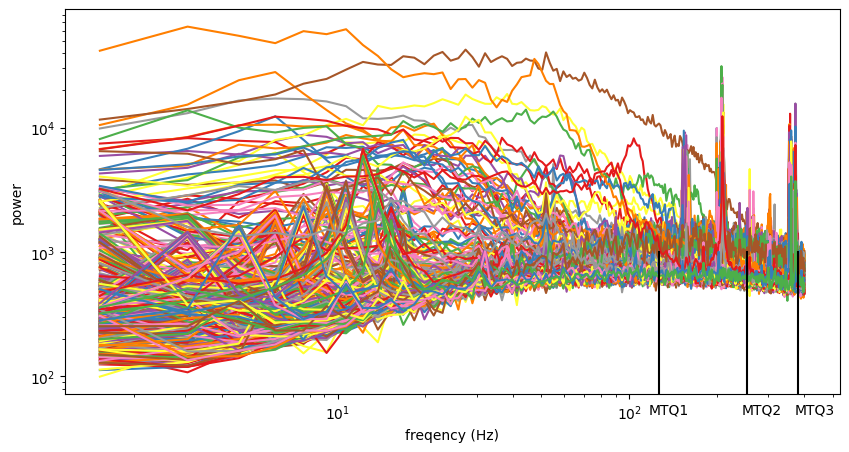

In [11]:
# test の可視化

fig,ax = plt.subplots(1,1,figsize=(10,5))

for d in df_test.iloc[510:1188,:].values.tolist():
    ax.plot(x,d)

#ax.set_ylim(0,4000)
ax.set_yscale("log")
ax.set_xscale("log")
ax.plot([127,127],[0,1000],color="black") #MTQ 82
ax.plot([254,254],[0,1000],color="black") # MTQ3 166 
ax.plot([381,381],[0,1000],color="black") # MTQ4 249

ax.text(127-10,50,"MTQ1")
ax.text(254-10,50,"MTQ2")
ax.text(381-10,50,"MTQ3")

ax.set_xlabel("freqency (Hz)")
ax.set_ylabel("power")

Text(0, 0.5, 'power')

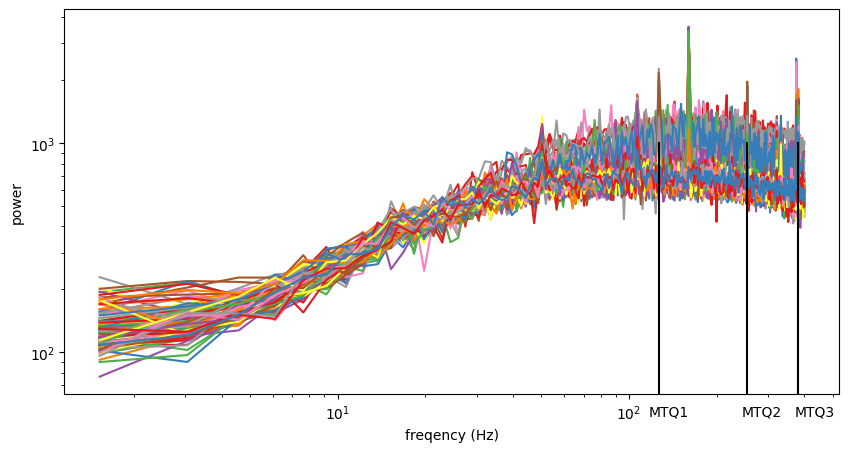

In [12]:
# test の可視化

fig,ax = plt.subplots(1,1,figsize=(10,5))

for d in df_test.iloc[1188:,:].values.tolist():
    ax.plot(x,d)

#ax.set_ylim(0,4000)
ax.set_yscale("log")
ax.set_xscale("log")
ax.plot([127,127],[0,1000],color="black") #MTQ 82
ax.plot([254,254],[0,1000],color="black") # MTQ3 166 
ax.plot([381,381],[0,1000],color="black") # MTQ4 249

ax.text(127-10,50,"MTQ1")
ax.text(254-10,50,"MTQ2")
ax.text(381-10,50,"MTQ3")

ax.set_xlabel("freqency (Hz)")
ax.set_ylabel("power")

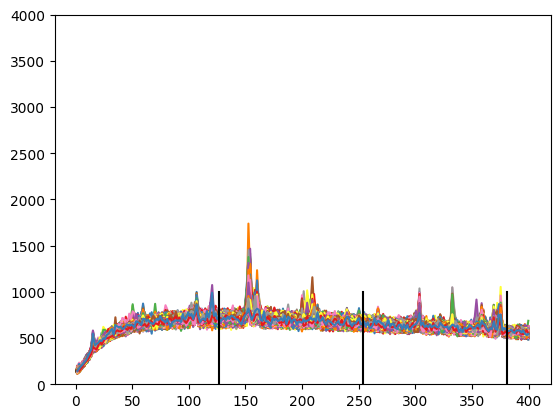

In [13]:
# train の可視化

fig,ax = plt.subplots()

for d in df_train.iloc[:2495,:].values.tolist():
    ax.plot(x,d)
    
ax.set_ylim(0,4000)
ax.plot([127,127],[0,1000],color="black") #MTQ 82
ax.plot([254,254],[0,1000],color="black") # MTQ3 166 
ax.plot([381,381],[0,1000],color="black") # MTQ4 249

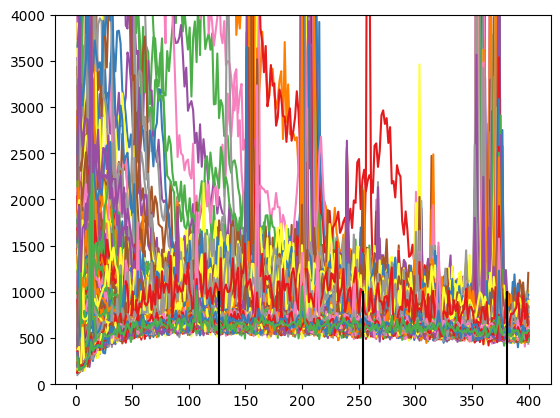

In [14]:
# train の可視化

fig,ax = plt.subplots()

for d in df_train.iloc[2495:3173,:].values.tolist():
    ax.plot(x,d)
    
ax.set_ylim(0,4000)
ax.plot([127,127],[0,1000],color="black") #MTQ 82
ax.plot([254,254],[0,1000],color="black") # MTQ3 166 
ax.plot([381,381],[0,1000],color="black") # MTQ4 249

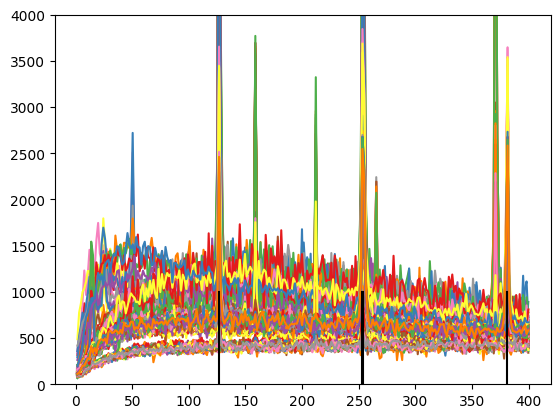

In [15]:
# train の可視化

fig,ax = plt.subplots()

for d in df_train.iloc[3173:,:].values.tolist():
    ax.plot(x,d)
    
ax.set_ylim(0,4000)
ax.plot([127,127],[0,1000],color="black") #MTQ 82
ax.plot([254,254],[0,1000],color="black") # MTQ3 165
ax.plot([381,381],[0,1000],color="black") # MTQ4 249
ax.plot([f_resolution*(165+1),f_resolution*(165+1)],[0,1000],color="black") # MTQ3 166

## SGD Classifier

In [16]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_approximation import RBFSampler

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [21]:
x_train,x_grid,y_train,y_grid = train_test_split(df_train_pre.values.tolist(),y_train_true,random_state=0,test_size=0.5)

sc = StandardScaler()
sc.fit(x_train)
x_train_std = sc.transform(x_train)

sc = StandardScaler()
sc.fit(x_grid)
x_grid_std = sc.transform(x_grid)

sc = StandardScaler()
sc.fit(x_grid)
x_test_std = sc.transform(df_test)

In [22]:
parameters = {
    "penalty":["l1","l2"],
    "alpha":[10**-7,10**-6,10**-5,10**-4,10**-3],
    "loss":["squared_hinge","hinge"]
    }
    

sgd = SGDClassifier(random_state=0)

S_grid = GridSearchCV(sgd,parameters,cv=3)

S_grid.fit(x_grid,y_grid)

print(S_grid.best_params_)

{'alpha': 1e-06, 'loss': 'hinge', 'penalty': 'l1'}


In [24]:
sgd = SGDClassifier(random_state=0,alpha=1e-06, loss= 'squared_hinge', penalty="l1")
sgd.fit(x_train_std,y_train)
df_sgd_predict = pd.DataFrame(sgd.predict(x_test_std))

(0.0, 4000.0)

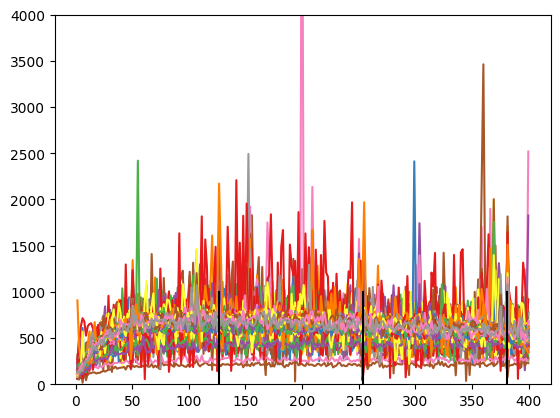

In [25]:
fig,ax = plt.subplots()
for d in df_test[(df_sgd_predict==-1)[0]].values.tolist():
    ax.plot(x,d)
plt.plot([127,127],[0,1000],color="black") #MTQ 82
plt.plot([254,254],[0,1000],color="black") # MTQ3 166 
plt.plot([381,381],[0,1000],color="black") # MTQ4 249

ax.set_ylim(0,4000)

(0.0, 4000.0)

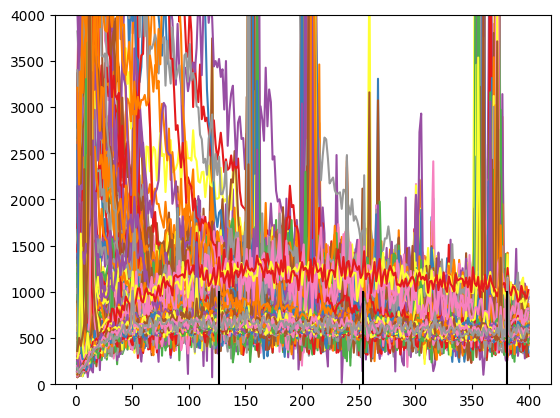

In [26]:
fig,ax = plt.subplots()
for d in df_test[(df_sgd_predict==-2)[0]].values.tolist():
    ax.plot(x,d)
plt.plot([127,127],[0,1000],color="black") #MTQ 82
plt.plot([254,254],[0,1000],color="black") # MTQ3 166 
plt.plot([381,381],[0,1000],color="black") # MTQ4 249
ax.set_ylim(0,4000)

(0.0, 4000.0)

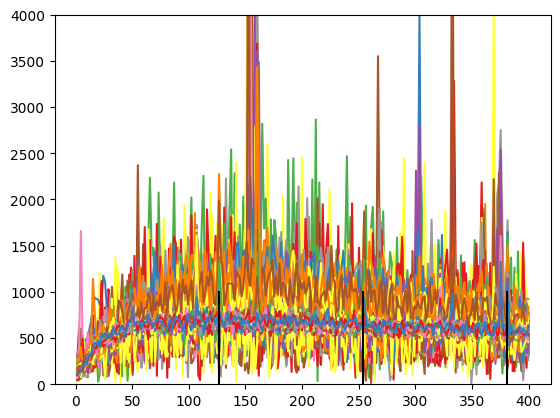

In [27]:
fig,ax = plt.subplots()
for d in df_test[(df_sgd_predict==1)[0]].values.tolist():
    ax.plot(x,d)
plt.plot([127,127],[0,1000],color="black") #MTQ 82
plt.plot([254,254],[0,1000],color="black") # MTQ3 166 
plt.plot([381,381],[0,1000],color="black") # MTQ4 249

ax.set_ylim(0,4000)

(0.0, 4000.0)

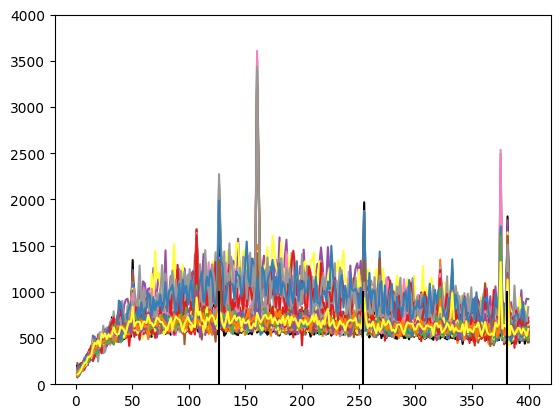

In [28]:
fig,ax = plt.subplots()
for d in df_test[(y_test_true==-1) & (df_sgd_predict==-1)[0]].values.tolist():
    ax.plot(x,d,color="black")
for d in df_test[(y_test_true==-1) & (df_sgd_predict==1)[0]].values.tolist():
    ax.plot(x,d)
    
plt.plot([127,127],[0,1000],color="black") #MTQ 82
plt.plot([254,254],[0,1000],color="black") # MTQ3 166 
plt.plot([381,381],[0,1000],color="black") # MTQ4 249

ax.set_ylim(0,4000)

(0.0, 4000.0)

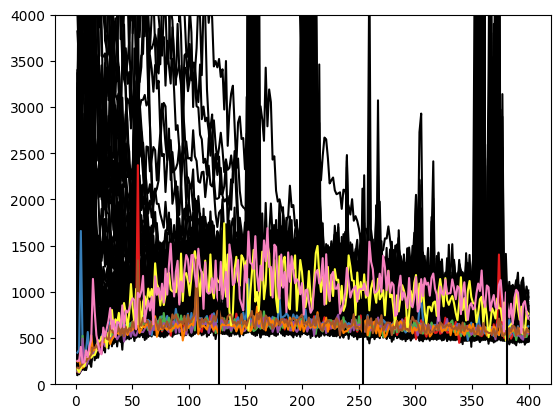

In [29]:
fig,ax = plt.subplots()
for d in df_test[(y_test_true==-2) & (df_sgd_predict==-2)[0]].values.tolist():
    ax.plot(x,d,color="black")
for d in df_test[(y_test_true==-2) & (df_sgd_predict==1)[0]].values.tolist():
    ax.plot(x,d)

plt.plot([127,127],[0,1000],color="black") #MTQ 82
plt.plot([254,254],[0,1000],color="black") # MTQ3 166 
plt.plot([381,381],[0,1000],color="black") # MTQ4 249

ax.set_ylim(0,4000)

(0.0, 4000.0)

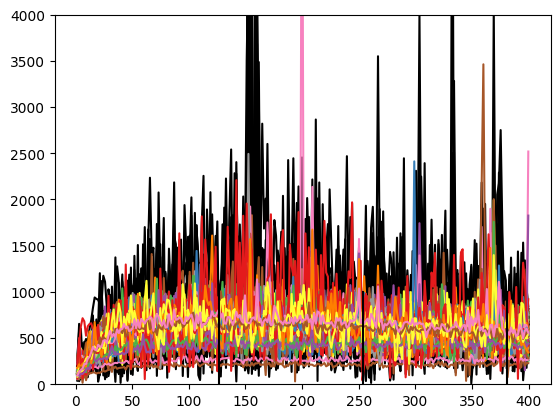

In [30]:
fig,ax = plt.subplots()
for d in df_test[(y_test_true==1) & (df_sgd_predict==1)[0]].values.tolist():
    ax.plot(x,d,color="black")
for d in df_test[(y_test_true==1) & (df_sgd_predict==-1)[0]].values.tolist():
    ax.plot(x,d)

plt.plot([127,127],[0,1000],color="black") #MTQ 82
plt.plot([254,254],[0,1000],color="black") # MTQ3 166 
plt.plot([381,381],[0,1000],color="black") # MTQ4 249

ax.set_ylim(0,4000)

In [31]:
confusion_matrix(y_test_true,df_sgd_predict)

array([[663,   7,   8],
       [ 20,  48,  96],
       [145, 125, 240]])

## KNN法

In [32]:
from sklearn.neighbors import KNeighborsClassifier

In [33]:
parameters = {
    "n_neighbors":list(range(10))
    }
    

knn = KNeighborsClassifier()

K_grid = GridSearchCV(knn,parameters,cv=3)

K_grid.fit(x_grid,y_grid)

print(K_grid.best_params_)

/usr/local/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/conda/lib/python3.7/site-packages/sklearn/neighbors/_classification.py", line 179, in fit
    return self._fit(X, y)
  File "/usr/local/conda/lib/python3.7/site-packages/sklearn/neighbors/_base.py", line 516, in _fit
    self.n_neighbors
ValueError: Expected n_neighbors > 0. Got 0

  FitFailedWarning)
/usr/local/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last)

{'n_neighbors': 2}


/usr/local/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan 0.96875123 0.97042627 0.96317429 0.96261501 0.95480281
 0.95591951 0.94866473 0.94810545 0.94420168]
  category=UserWarning


In [35]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(x_train_std,y_train)
df_knn_predict = pd.DataFrame(knn.predict(x_test_std))

In [36]:
confusion_matrix(y_test_true,df_knn_predict)

array([[334,  13, 331],
       [  3,   9, 152],
       [ 37,  24, 449]])

## 再構成二乗誤差法

In [61]:
# sc = StandardScaler()
# sc.fit(df_test)
# List_test_std = sc.transform(df_test)


# sc = StandardScaler()
# sc.fit(df_train_)
# List_train_std = sc.transform(df_train_)

List_test_std = df_test.values.tolist()
List_train_std = df_train.values.tolist()

In [62]:
import functools
from sklearn.decomposition import PCA
def J_PCA(k,X_train,X_test=False):
    
    if X_test == False:
        X_test = X_train
    
    pca = PCA(n_components=k,random_state=0)
    pca.fit(X_train)
    
    W = pca.components_
    mu = np.array(X_test).mean(axis=0)
    
    y_expect = np.array(list(map(functools.partial(y_recon_func,W=W,mu=mu),X_test)))
    gosa = y_expect-X_test
    J_pca = np.sum(gosa**2,axis=1)
    
    return J_pca

def y_recon_func(x,W,mu):
    return np.dot(W.T,np.dot(W,x-mu))+mu

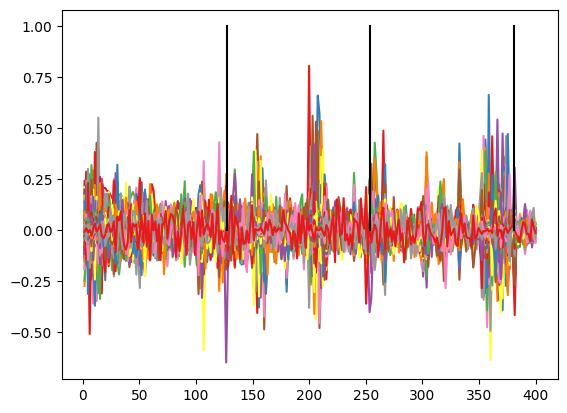

In [63]:
pca = PCA(n_components=200)
pca.fit(List_train_std)
List_pca_result_kari = pca.transform(List_train_std)

for i in range(100):
    plt.plot(x,pca.components_[i],label=f"{i}")
plt.plot([127,127],[0,1],color="black") #MTQ 82
plt.plot([254,254],[0,1],color="black") # MTQ3 166 
plt.plot([381,381],[0,1],color="black") # MTQ4 249


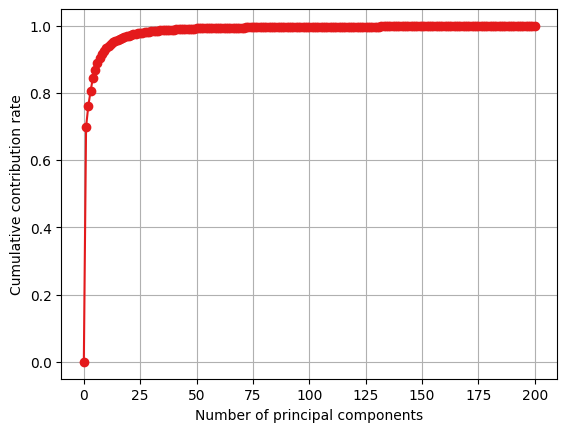

In [64]:

import matplotlib.ticker as ticker
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.plot([0] + list( np.cumsum(pca.explained_variance_ratio_)), "-o")
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative contribution rate")
plt.grid()
plt.show()

In [65]:
k = 150

pca = PCA(n_components=k,random_state=0)
pca.fit(List_train_std)
    
W = pca.components_
mu = np.array(List_test_std).mean(axis=0)
    
y_expect = np.array(list(map(functools.partial(y_recon_func,W=W,mu=mu),List_test_std)))
gosa = y_expect-List_test_std
J_pca = np.sum(gosa**2,axis=1)

J_PCA_List = pd.DataFrame(J_pca)

Text(0, 0.5, 'anomaly rate')

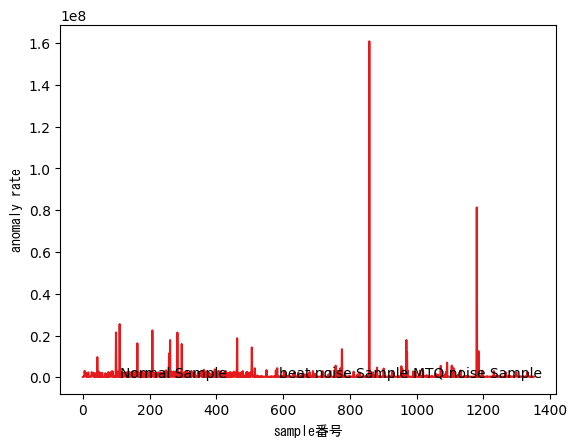

In [66]:
fig,ax = plt.subplots()

lim = len(J_PCA_List)

ax.plot(range(len(J_PCA_List)),J_PCA_List)
ax.plot([len(df_test_),len(df_test_)],[0,1000],color="blue")
ax.plot([len(df_test_)+len(df_ImamuraAbnormal_test),len(df_test_)+len(df_ImamuraAbnormal_test)],[0,1000],color="blue")

ax.text(len(df_test_)-400,800,"Normal Sample")
ax.text(len(df_test_)+len(df_ImamuraAbnormal_test)-600,800,"beat noise Sample")
ax.text(len(df_test_)+len(df_ImamuraAbnormal_test)-200,1400,"MTQ noise Sample")
ax.set_xlabel("sample番号",fontname="MS Gothic")
ax.set_ylabel("anomaly rate",fontname="MS Gothic")

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([     0.,   1000.,   2000.,   3000.,   4000.,   5000.,   6000.,
          7000.,   8000.,   9000.,  10000.,  11000.,  12000.,  13000.,
         14000.,  15000.,  16000.,  17000.,  18000.,  19000.,  20000.,
         21000.,  22000.,  23000.,  24000.,  25000.,  26000.,  27000.,
         28000.,  29000.,  30000.,  31000.,  32000.,  33000.,  34000.,
         35000.,  36000.,  37000.,  38000.,  39000.,  40000.,  41000.,
         42000.,  43000.,  44000.,  45000.,  46000.,  47000.,  48000.,
         49000.,  50000.,  51000.,  52000.,  53000., 

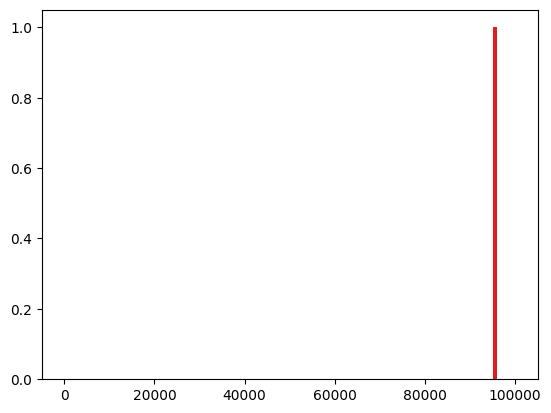

In [67]:
fig,ax = plt.subplots()
ax.hist(J_PCA_List,bins=100,range=[0,100000])

In [68]:
import copy
y_PCA_true = copy.copy(y_test_true)
y_PCA_true[y_test_true<0] = -1


In [69]:
List_PCA_result = []
for lim in range(0,20000000,10000):
    y_PCA_pred = np.ones(len(df_test))
    y_PCA_pred[J_PCA_List[(J_PCA_List>lim)[0]].index]=-1
    m = confusion_matrix(y_PCA_true,y_PCA_pred)
    
    FP = m[1][0]/sum(m[1])
    TP = m[0][0]/sum(m[0])
    
    List_PCA_result.append([FP,TP])
    

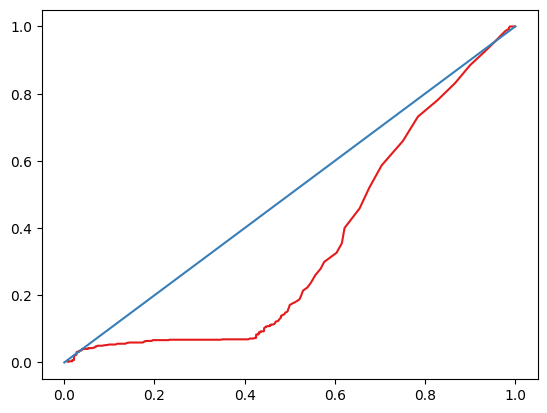

In [70]:
List_PCA_result = np.array(List_PCA_result)
fig,ax = plt.subplots()

ax.plot(List_PCA_result.T[0],List_PCA_result.T[1])
ax.plot([0,1],[0,1])

(0.0, 4000.0)

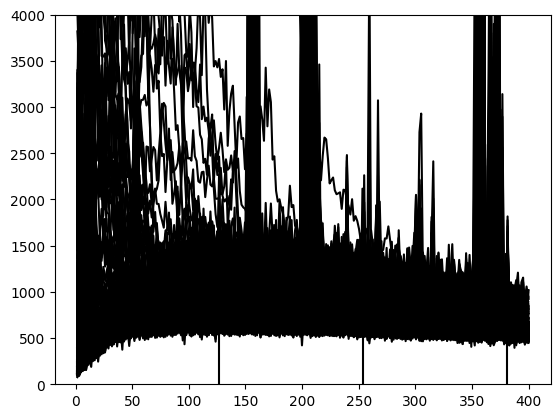

In [71]:
lim = 199
y_PCA_pred = np.ones(len(df_test))
y_PCA_pred[J_PCA_List[(J_PCA_List>lim)[0]].index]=-1

fig,ax = plt.subplots()
for d in df_test[(y_PCA_true==-1) & (y_PCA_pred==-1)].values.tolist():
    ax.plot(x,d,color="black")
for d in df_test[(y_PCA_true==-1) & (y_PCA_pred==1)].values.tolist():
    ax.plot(x,d)

plt.plot([127,127],[0,1000],color="black") #MTQ 82
plt.plot([254,254],[0,1000],color="black") # MTQ3 166 
plt.plot([381,381],[0,1000],color="black") # MTQ4 249

ax.set_ylim(0,4000)

(0.0, 4000.0)

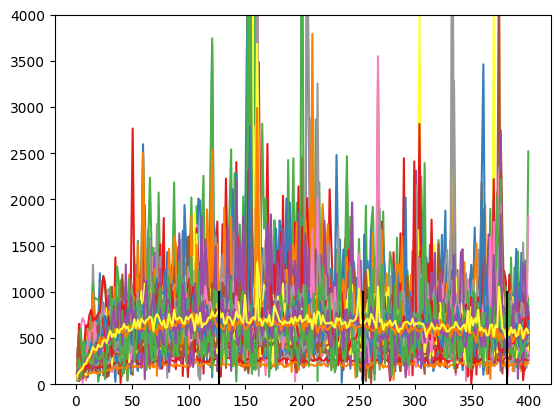

In [72]:
lim = 71
y_PCA_pred = np.ones(len(df_test))
y_PCA_pred[J_PCA_List[(J_PCA_List>lim)[0]].index]=-1

fig,ax = plt.subplots()
for d in df_test[(y_PCA_true==1) & (y_PCA_pred==1)].values.tolist():
    ax.plot(x,d,color="black")
for d in df_test[(y_PCA_true==1) & (y_PCA_pred==-1)].values.tolist():
    ax.plot(x,d)

plt.plot([127,127],[0,1000],color="black") #MTQ 82
plt.plot([254,254],[0,1000],color="black") # MTQ3 166 
plt.plot([381,381],[0,1000],color="black") # MTQ4 249

ax.set_ylim(0,4000)

## 再構成二乗誤差法　kmeans

In [73]:
import numpy as np
def J_Kmeans(k,X_train,X_test):
    np_test = np.array(X_test)
    miniKM = MiniBatchKMeans(n_clusters=k,random_state=0)
    miniKM.fit(X_train)
    centers = miniKM.cluster_centers_
    clusters = miniKM.predict(X_test)
    cluster_centers = np.array([centers[i] for i in clusters])
    gosa_vectors =  cluster_centers-np_test
    gosas = np.sqrt(np.sum(gosa_vectors**2,axis=1))
    return gosas

In [74]:
k=1

In [75]:
from sklearn.cluster import MiniBatchKMeans

In [76]:
J_KMeans_List=J_Kmeans(k,List_train_std,List_test_std)
J_KMeans_List = pd.DataFrame(J_KMeans_List)
J_KMeans_List.index = df_test.index
J_KMeans_List

0
0     1305.288131
1     1319.874583
2     1407.024624
3     2132.147370
4     1475.784249
...           ...
1347  1560.249370
1348  1282.454690
1349  1226.974281
1350  1331.055925
1351  1326.531732

[1352 rows x 1 columns]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([  0.,   6.,  12.,  18.,  24.,  30.,  36.,  42.,  48.,  54.,  60.,
         66.,  72.,  78.,  84.,  90.,  96., 102., 108., 114., 120., 126.,
        132., 138., 144., 150., 156., 162., 168., 174., 180., 186., 192.,
        198., 204., 210., 216., 222., 228., 234., 240., 246., 252., 258.,
        264., 270., 276., 282., 288., 294., 300., 306., 312., 318., 324.,
        330., 336., 342., 348., 354., 360., 366., 372., 378., 384., 390.,
        396., 402., 408., 414., 420., 426., 432., 438., 444., 450., 456.,
        462., 468., 474., 480., 

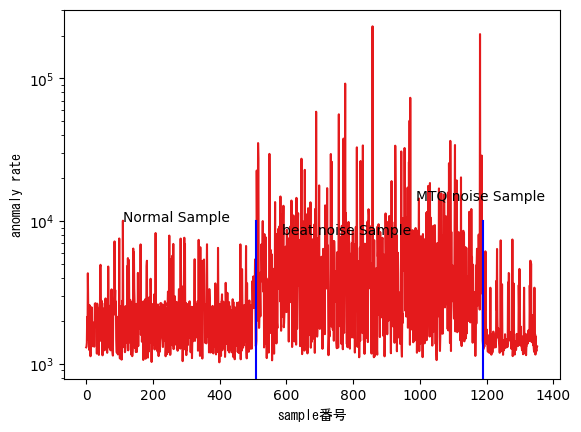

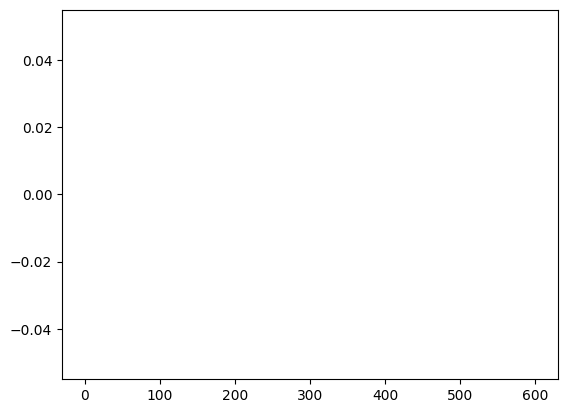

In [82]:
fig,ax = plt.subplots()

ax.plot(range(len(J_KMeans_List)),J_KMeans_List)
ax.plot([len(df_test_),len(df_test_)],[0,10000],color="blue")
ax.plot([len(df_test_)+len(df_ImamuraAbnormal_test),len(df_test_)+len(df_ImamuraAbnormal_test)],[0,10000],color="blue")
ax.set_yscale("log")

ax.text(len(df_test_)-400,10000,"Normal Sample")
ax.text(len(df_test_)+len(df_ImamuraAbnormal_test)-600,8000,"beat noise Sample")
ax.text(len(df_test_)+len(df_ImamuraAbnormal_test)-200,14000,"MTQ noise Sample")
ax.set_xlabel("sample番号",fontname="MS Gothic")
ax.set_ylabel("anomaly rate",fontname="MS Gothic")

fig,ax = plt.subplots()

ax.hist(J_KMeans_List,bins=100,range=[0,600])



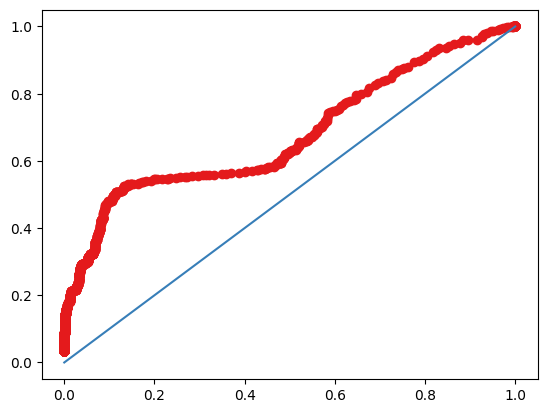

In [78]:
import copy
from sklearn.metrics import confusion_matrix

y_Kmeans_true = copy.copy(y_test_true)
y_Kmeans_true[y_test_true<0] = -1

List_Kmeans_result = []

for lim in range(0,20000,10):
    y_Kmeans_pred = np.ones(len(df_test))
    y_Kmeans_pred[J_KMeans_List[(J_KMeans_List>lim)[0]].index]=-1
    m = confusion_matrix(y_Kmeans_true,y_Kmeans_pred)
    
    FP = m[1][0]/sum(m[1])
    TP = m[0][0]/sum(m[0])
    
    List_Kmeans_result.append([FP,TP])

List_Kmeans_result = np.array(List_Kmeans_result)
fig,ax = plt.subplots()

ax.plot(List_Kmeans_result.T[0],List_Kmeans_result.T[1])
ax.plot([0,1],[0,1])
ax.scatter(List_Kmeans_result.T[0],List_Kmeans_result.T[1])

In [79]:
np.where((0.5>List_Kmeans_result.T[0])&(List_Kmeans_result.T[0]>0.1))

(array([208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,
        221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246,
        247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259,
        260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272,
        273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285,
        286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298,
        299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311,
        312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324,
        325, 326, 327, 328, 329, 330, 331, 332]),)

(0.0, 4000.0)

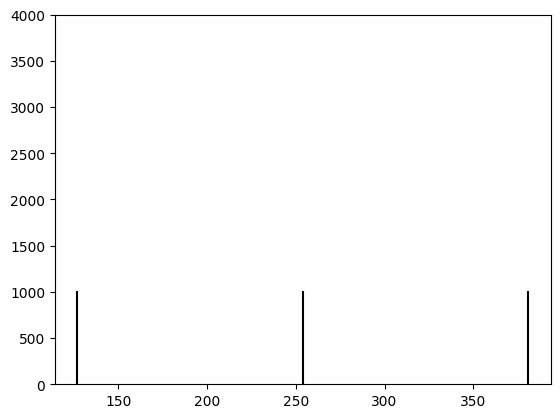

In [80]:
fig,ax = plt.subplots()
for d in df_test[(J_KMeans_List>60)[0] & (J_KMeans_List<80)[0]&(y_test_true==1)].values.tolist():
    ax.plot(x,d)
plt.plot([127,127],[0,1000],color="black") #MTQ 82
plt.plot([254,254],[0,1000],color="black") # MTQ3 165 
plt.plot([381,381],[0,1000],color="black") # MTQ4 249

ax.set_ylim(0,4000)

In [ ]:
fig,ax = plt.subplots()
for d in df_test[(J_KMeans_List>60)[0] & (J_KMeans_List<80)[0]&(y_test_true==1)].values.tolist():
    ax.plot(x,d,color="black")
for d in df_test[(J_KMeans_List<60)[0] &(y_test_true==1)].values.tolist():
    ax.plot(x,d)
plt.plot([127,127],[0,1000],color="black") #MTQ 82
plt.plot([254,254],[0,1000],color="black") # MTQ3 165 
plt.plot([381,381],[0,1000],color="black") # MTQ4 249

ax.set_ylim(0,4000)

In [ ]:
# One Class SVC

In [ ]:
from sklearn.svm import OneClassSVM

sc = StandardScaler()
sc.fit(df_train_)
List_train_std = sc.transform(df_train_)



List_OneClass_result = []

for nu in [1,0.1,0.01,0.001,0.00001]:

    ocsvm = OneClassSVM(nu=nu)
    ocsvm.fit(List_train_std)
    df_unsu_ocsvm_result = ocsvm.predict(List_test_std)
    df_unsu_ocsvm_result = pd.DataFrame(df_unsu_ocsvm_result)
    df_unsu_ocsvm_result.index = df_test.index
    df_unsu_ocsvm_result

    df_unsp_ocsvm_normal = df_test[df_test.index.isin(df_unsu_ocsvm_result[df_unsu_ocsvm_result[0]==-1].index)]
    List_unsp_ocsvm_normal = df_unsu_ocsvm_result[0].values.tolist()
    m = confusion_matrix(y_Kmeans_true,List_unsp_ocsvm_normal)
    
    FP = m[1][0]/sum(m[1])
    TP = m[0][0]/sum(m[0])
    
    List_OneClass_result.append([FP,TP])

List_OneClass_result = np.array(List_OneClass_result)

fig,ax = plt.subplots()

ax.plot(List_OneClass_result.T[0],List_OneClass_result.T[1])
ax.plot([0,1],[0,1])



## KNN法

In [73]:
sc = StandardScaler()
sc.fit(df_train_)
List_train_std = sc.transform(df_train_)

List_train_std = df_test_.values.tolist()

In [76]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

def KNNAnomalyRate(k,trainList,testList):
    
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(trainList)
    neig,ind = nn.kneighbors(testList)

    return neig
    

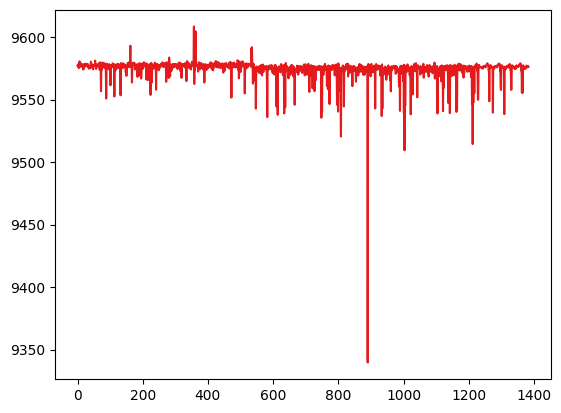

In [90]:
fig,ax = plt.subplots()

List_KNN_rate = KNNAnomalyRate(10,List_train_std,List_test_std)
ax.plot(range(len(List_KNN_rate)),List_KNN_rate.T[9])